In [44]:
import pandas as pd
import numpy as np
import sklearn

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm, tqdm_notebook

### load dataset

In [45]:
# definir o device
device = torch.device("cpu")
device

device(type='cpu')

In [46]:
col_names = ["review", "sentiment"]
dados_filmes = pd.read_csv("data/imdb_reviews.csv", sep="\t", names=col_names)
dados_filmes

,review,sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1
...,...,...
743,I just got bored watching Jessice Lange take h...,0
744,"Unfortunately, any virtue in this film's produ...",0
745,"In a word, it is embarrassing.",0
746,Exceptionally bad!,0


In [47]:
dados_filmes.shape

(748, 2)

(<AxesSubplot:xlabel='sentiment', ylabel='Count'>,
 1    386
 0    362
 Name: sentiment, dtype: int64)

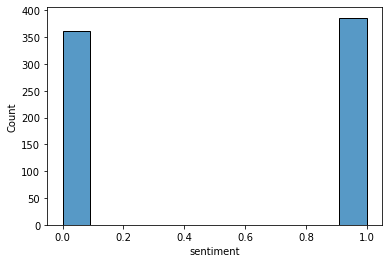

In [48]:
sns.histplot(data=dados_filmes["sentiment"]), dados_filmes["sentiment"].value_counts()

### Manipulação do texto

In [49]:
# vetorização do texto com sklearn.
# vectorizer -> sparse matrix
vectorizer = CountVectorizer(stop_words= "english", max_df=0.99, min_df=0.005) # instância da classe CountVectorizer
vectorizer

CountVectorizer(max_df=0.99, min_df=0.005, stop_words='english')

In [50]:
# Sequencias do texto com o vetorizador
sequences = vectorizer.fit_transform(dados_filmes.review.to_list()) # fit realiza a construção da matriz esparsa
sequences # matriz espars com 748 X 320

<748x320 sparse matrix of type '<class 'numpy.int64'>'
	with 2931 stored elements in Compressed Sparse Row format>

In [51]:
labels = dados_filmes.sentiment.to_list()

In [52]:
# Dicionario de frequencia de palavras -> bago of words
token2idx =vectorizer.vocabulary_ # o atributo vocabulary_ contem o dicionario de frquencia dos words

In [53]:
token2idx, type(token2idx), len(token2idx)

({'slow': 248,
  'moving': 185,
  'movie': 183,
  'young': 319,
  'man': 171,
  'lost': 162,
  'characters': 41,
  'audience': 14,
  'half': 119,
  'black': 28,
  'white': 305,
  'clever': 48,
  'camera': 35,
  'disappointed': 73,
  'ridiculous': 227,
  'acting': 3,
  'poor': 211,
  'plot': 209,
  'lines': 156,
  'non': 190,
  'little': 157,
  'music': 186,
  'best': 24,
  'scene': 234,
  'trying': 285,
  'rest': 226,
  'lacks': 147,
  'art': 12,
  'works': 310,
  'guess': 118,
  'wasted': 300,
  'saw': 232,
  'today': 278,
  'thought': 275,
  'good': 115,
  'kids': 144,
  'bit': 27,
  'predictable': 213,
  'loved': 165,
  'casting': 38,
  'adorable': 8,
  'lot': 163,
  'look': 160,
  'songs': 251,
  'hilarious': 122,
  'cool': 55,
  'right': 228,
  'face': 92,
  'low': 167,
  'budget': 33,
  'long': 159,
  'consider': 53,
  'tale': 266,
  'single': 247,
  'film': 101,
  'll': 158,
  'cinematography': 46,
  'production': 218,
  'editing': 78,
  'directing': 70,
  'making': 170,
  'perf

In [54]:
token2idx["bad"] # a palavra bad apareceu 18 vezes

18

In [55]:
# É possível inverter os keys : values da lista:
idx2token = {}
for key, value in token2idx.items():
    idx2token[value] = key
idx2token

{248: 'slow',
 185: 'moving',
 183: 'movie',
 319: 'young',
 171: 'man',
 162: 'lost',
 41: 'characters',
 14: 'audience',
 119: 'half',
 28: 'black',
 305: 'white',
 48: 'clever',
 35: 'camera',
 73: 'disappointed',
 227: 'ridiculous',
 3: 'acting',
 211: 'poor',
 209: 'plot',
 156: 'lines',
 190: 'non',
 157: 'little',
 186: 'music',
 24: 'best',
 234: 'scene',
 285: 'trying',
 226: 'rest',
 147: 'lacks',
 12: 'art',
 310: 'works',
 118: 'guess',
 300: 'wasted',
 232: 'saw',
 278: 'today',
 275: 'thought',
 115: 'good',
 144: 'kids',
 27: 'bit',
 213: 'predictable',
 165: 'loved',
 38: 'casting',
 8: 'adorable',
 163: 'lot',
 160: 'look',
 251: 'songs',
 122: 'hilarious',
 55: 'cool',
 228: 'right',
 92: 'face',
 167: 'low',
 33: 'budget',
 159: 'long',
 53: 'consider',
 266: 'tale',
 247: 'single',
 101: 'film',
 158: 'll',
 46: 'cinematography',
 218: 'production',
 78: 'editing',
 70: 'directing',
 170: 'making',
 200: 'perfect',
 283: 'true',
 123: 'history',
 45: 'cinema',
 274:

### classe para criação do bag of words - opção número 2

In [56]:
class Sequences():
    def __init__(self):
        self.vectorizer = CountVectorizer(stop_words= "english", max_df=0.99, min_df=0.005)
        self.sequences = self.vectorizer.fit_transform(dados_filmes.review.tolist())
        self.labels = dados_filmes.sentiment.tolist()
        self.token2idx = self.vectorizer.vocabulary_
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}
    
    def __getitem__(self, i):
        return(self.sequences[i, :].toarray(), self.labels[i])
    
    def __len__(self):
        return(self.sequences.shape[0])
    

In [57]:
# instancia da classe Sequences:
transform_text = Sequences()

In [58]:
# método inverter os tokens
transform_text.idx2token

{248: 'slow',
 185: 'moving',
 183: 'movie',
 319: 'young',
 171: 'man',
 162: 'lost',
 41: 'characters',
 14: 'audience',
 119: 'half',
 28: 'black',
 305: 'white',
 48: 'clever',
 35: 'camera',
 73: 'disappointed',
 227: 'ridiculous',
 3: 'acting',
 211: 'poor',
 209: 'plot',
 156: 'lines',
 190: 'non',
 157: 'little',
 186: 'music',
 24: 'best',
 234: 'scene',
 285: 'trying',
 226: 'rest',
 147: 'lacks',
 12: 'art',
 310: 'works',
 118: 'guess',
 300: 'wasted',
 232: 'saw',
 278: 'today',
 275: 'thought',
 115: 'good',
 144: 'kids',
 27: 'bit',
 213: 'predictable',
 165: 'loved',
 38: 'casting',
 8: 'adorable',
 163: 'lot',
 160: 'look',
 251: 'songs',
 122: 'hilarious',
 55: 'cool',
 228: 'right',
 92: 'face',
 167: 'low',
 33: 'budget',
 159: 'long',
 53: 'consider',
 266: 'tale',
 247: 'single',
 101: 'film',
 158: 'll',
 46: 'cinematography',
 218: 'production',
 78: 'editing',
 70: 'directing',
 170: 'making',
 200: 'perfect',
 283: 'true',
 123: 'history',
 45: 'cinema',
 274:

###  Converter os dados para o formato Torch

In [59]:
train_loader = DataLoader(transform_text, batch_size = 4096)
train_loader

### Construção do modelo

In [60]:
# rede Neural
class BagOfWordsClassifier(nn.Module):
    def __init__(self, vocab_size, hidden1, hidden2):
        super(BagOfWordsClassifier, self).__init__()
        self.fc1 = nn.Linear(in_features=vocab_size, out_features=hidden1)
        self.fc2 = nn.Linear(in_features=hidden1, out_features=hidden2)
        self.fc3 = nn.Linear(in_features=hidden2, out_features=1) # ultima camada com 1 saida por ser binário.
    
    def forward(self, inputs):
        x = F.relu(self.fc1(inputs.squeeze(1).float()))
        x = F.relu(self.fc2(x))
        return(self.fc3(x))

In [61]:
# modelo
model = BagOfWordsClassifier(vocab_size=len(transform_text.token2idx), hidden1= 128, hidden2=64)
model

BagOfWordsClassifier(
  (fc1): Linear(in_features=320, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [62]:
# Loss Function
criterion = nn.BCEWithLogitsLoss() # Binary Cross Entropy -> por ser tratar de classificação binária

In [63]:
# optmizer
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr= 0.001)

### Model Training

In [65]:
train_losses = []
epochs = 200
model.train()

for epochs in range(epochs):
    losses = []
    total = 0
    progress_bar = tqdm_notebook(train_loader, leave=False)
    
    for inputs, target in progress_bar:
        model.zero_grad() # inicialização dos gradientes
        output = model(inputs)
        loss = criterion(output.squeeze(), target.float())
        loss.backward() # backpropagation instance
        nn.utils.clip_grad_norm_(model.parameters(), 3) # atualizar os coeficientes
        optimizer.step() # execução do optimizador
        losses.append(loss.item())
        total += 1
    
    epoch_loss = sum(losses) / total
    train_losses.append(epoch_loss)
    print(epoch_loss)

  0%|          | 0/1 [00:00<?, ?it/s]

0.6269261240959167


  0%|          | 0/1 [00:00<?, ?it/s]

0.619718611240387


  0%|          | 0/1 [00:00<?, ?it/s]

0.6119898557662964


  0%|          | 0/1 [00:00<?, ?it/s]

0.6037408113479614


  0%|          | 0/1 [00:00<?, ?it/s]

0.5949747562408447


  0%|          | 0/1 [00:00<?, ?it/s]

0.585700511932373


  0%|          | 0/1 [00:00<?, ?it/s]

0.5759017467498779


  0%|          | 0/1 [00:00<?, ?it/s]

0.5655960440635681


  0%|          | 0/1 [00:00<?, ?it/s]

0.5547959208488464


  0%|          | 0/1 [00:00<?, ?it/s]

0.5435391068458557


  0%|          | 0/1 [00:00<?, ?it/s]

0.5318428874015808


  0%|          | 0/1 [00:00<?, ?it/s]

0.5197474360466003


  0%|          | 0/1 [00:00<?, ?it/s]

0.5073107481002808


  0%|          | 0/1 [00:00<?, ?it/s]

0.4945979118347168


  0%|          | 0/1 [00:00<?, ?it/s]

0.4816548824310303


  0%|          | 0/1 [00:00<?, ?it/s]

0.46854135394096375


  0%|          | 0/1 [00:00<?, ?it/s]

0.455315500497818


  0%|          | 0/1 [00:00<?, ?it/s]

0.44205641746520996


  0%|          | 0/1 [00:00<?, ?it/s]

0.42884641885757446


  0%|          | 0/1 [00:00<?, ?it/s]

0.41576090455055237


  0%|          | 0/1 [00:00<?, ?it/s]

0.40284979343414307


  0%|          | 0/1 [00:00<?, ?it/s]

0.39017507433891296


  0%|          | 0/1 [00:00<?, ?it/s]

0.37778380513191223


  0%|          | 0/1 [00:00<?, ?it/s]

0.36572298407554626


  0%|          | 0/1 [00:00<?, ?it/s]

0.35402247309684753


  0%|          | 0/1 [00:00<?, ?it/s]

0.34271982312202454


  0%|          | 0/1 [00:00<?, ?it/s]

0.33184483647346497


  0%|          | 0/1 [00:00<?, ?it/s]

0.3214165270328522


  0%|          | 0/1 [00:00<?, ?it/s]

0.3114311993122101


  0%|          | 0/1 [00:00<?, ?it/s]

0.30188867449760437


  0%|          | 0/1 [00:00<?, ?it/s]

0.29278767108917236


  0%|          | 0/1 [00:00<?, ?it/s]

0.28411731123924255


  0%|          | 0/1 [00:00<?, ?it/s]

0.2758595943450928


  0%|          | 0/1 [00:00<?, ?it/s]

0.2679966688156128


  0%|          | 0/1 [00:00<?, ?it/s]

0.26051095128059387


  0%|          | 0/1 [00:00<?, ?it/s]

0.2533874809741974


  0%|          | 0/1 [00:00<?, ?it/s]

0.24660617113113403


  0%|          | 0/1 [00:00<?, ?it/s]

0.24015793204307556


  0%|          | 0/1 [00:00<?, ?it/s]

0.23402315378189087


  0%|          | 0/1 [00:00<?, ?it/s]

0.22817307710647583


  0%|          | 0/1 [00:00<?, ?it/s]

0.22260141372680664


  0%|          | 0/1 [00:00<?, ?it/s]

0.21728216111660004


  0%|          | 0/1 [00:00<?, ?it/s]

0.21221083402633667


  0%|          | 0/1 [00:00<?, ?it/s]

0.20736731588840485


  0%|          | 0/1 [00:00<?, ?it/s]

0.20273292064666748


  0%|          | 0/1 [00:00<?, ?it/s]

0.19830010831356049


  0%|          | 0/1 [00:00<?, ?it/s]

0.19405357539653778


  0%|          | 0/1 [00:00<?, ?it/s]

0.18997658789157867


  0%|          | 0/1 [00:00<?, ?it/s]

0.18606872856616974


  0%|          | 0/1 [00:00<?, ?it/s]

0.18231748044490814


  0%|          | 0/1 [00:00<?, ?it/s]

0.17872007191181183


  0%|          | 0/1 [00:00<?, ?it/s]

0.17526023089885712


  0%|          | 0/1 [00:00<?, ?it/s]

0.17192786931991577


  0%|          | 0/1 [00:00<?, ?it/s]

0.16871291399002075


  0%|          | 0/1 [00:00<?, ?it/s]

0.16561084985733032


  0%|          | 0/1 [00:00<?, ?it/s]

0.1626191884279251


  0%|          | 0/1 [00:00<?, ?it/s]

0.1597364842891693


  0%|          | 0/1 [00:00<?, ?it/s]

0.15695318579673767


  0%|          | 0/1 [00:00<?, ?it/s]

0.1542656570672989


  0%|          | 0/1 [00:00<?, ?it/s]

0.15166506171226501


  0%|          | 0/1 [00:00<?, ?it/s]

0.14913754165172577


  0%|          | 0/1 [00:00<?, ?it/s]

0.14667370915412903


  0%|          | 0/1 [00:00<?, ?it/s]

0.1442846953868866


  0%|          | 0/1 [00:00<?, ?it/s]

0.1419627070426941


  0%|          | 0/1 [00:00<?, ?it/s]

0.1397019922733307


  0%|          | 0/1 [00:00<?, ?it/s]

0.1375015676021576


  0%|          | 0/1 [00:00<?, ?it/s]

0.13537144660949707


  0%|          | 0/1 [00:00<?, ?it/s]

0.13329407572746277


  0%|          | 0/1 [00:00<?, ?it/s]

0.1312674731016159


  0%|          | 0/1 [00:00<?, ?it/s]

0.12929904460906982


  0%|          | 0/1 [00:00<?, ?it/s]

0.12739036977291107


  0%|          | 0/1 [00:00<?, ?it/s]

0.12553554773330688


  0%|          | 0/1 [00:00<?, ?it/s]

0.12373246997594833


  0%|          | 0/1 [00:00<?, ?it/s]

0.12197740375995636


  0%|          | 0/1 [00:00<?, ?it/s]

0.12027230858802795


  0%|          | 0/1 [00:00<?, ?it/s]

0.11861947923898697


  0%|          | 0/1 [00:00<?, ?it/s]

0.11701628565788269


  0%|          | 0/1 [00:00<?, ?it/s]

0.1154661551117897


  0%|          | 0/1 [00:00<?, ?it/s]

0.11396367102861404


  0%|          | 0/1 [00:00<?, ?it/s]

0.11250476539134979


  0%|          | 0/1 [00:00<?, ?it/s]

0.11108580231666565


  0%|          | 0/1 [00:00<?, ?it/s]

0.10970988869667053


  0%|          | 0/1 [00:00<?, ?it/s]

0.10837607830762863


  0%|          | 0/1 [00:00<?, ?it/s]

0.10708310455083847


  0%|          | 0/1 [00:00<?, ?it/s]

0.10583028197288513


  0%|          | 0/1 [00:00<?, ?it/s]

0.10462077707052231


  0%|          | 0/1 [00:00<?, ?it/s]

0.10345003753900528


  0%|          | 0/1 [00:00<?, ?it/s]

0.10231535881757736


  0%|          | 0/1 [00:00<?, ?it/s]

0.10121913999319077


  0%|          | 0/1 [00:00<?, ?it/s]

0.10015752166509628


  0%|          | 0/1 [00:00<?, ?it/s]

0.09912755340337753


  0%|          | 0/1 [00:00<?, ?it/s]

0.09813034534454346


  0%|          | 0/1 [00:00<?, ?it/s]

0.09716056287288666


  0%|          | 0/1 [00:00<?, ?it/s]

0.09621896594762802


  0%|          | 0/1 [00:00<?, ?it/s]

0.09530510008335114


  0%|          | 0/1 [00:00<?, ?it/s]

0.09441583603620529


  0%|          | 0/1 [00:00<?, ?it/s]

0.0935504138469696


  0%|          | 0/1 [00:00<?, ?it/s]

0.09270806610584259


  0%|          | 0/1 [00:00<?, ?it/s]

0.09188798069953918


  0%|          | 0/1 [00:00<?, ?it/s]

0.09108896553516388


  0%|          | 0/1 [00:00<?, ?it/s]

0.09031188488006592


  0%|          | 0/1 [00:00<?, ?it/s]

0.08955955505371094


  0%|          | 0/1 [00:00<?, ?it/s]

0.08883205056190491


  0%|          | 0/1 [00:00<?, ?it/s]

0.08812680840492249


  0%|          | 0/1 [00:00<?, ?it/s]

0.08744543045759201


  0%|          | 0/1 [00:00<?, ?it/s]

0.0867866799235344


  0%|          | 0/1 [00:00<?, ?it/s]

0.08614932000637054


  0%|          | 0/1 [00:00<?, ?it/s]

0.08553433418273926


  0%|          | 0/1 [00:00<?, ?it/s]

0.08494096994400024


  0%|          | 0/1 [00:00<?, ?it/s]

0.08436654508113861


  0%|          | 0/1 [00:00<?, ?it/s]

0.08381045609712601


  0%|          | 0/1 [00:00<?, ?it/s]

0.08327129483222961


  0%|          | 0/1 [00:00<?, ?it/s]

0.08274945616722107


  0%|          | 0/1 [00:00<?, ?it/s]

0.08224496245384216


  0%|          | 0/1 [00:00<?, ?it/s]

0.08175733685493469


  0%|          | 0/1 [00:00<?, ?it/s]

0.08128578960895538


  0%|          | 0/1 [00:00<?, ?it/s]

0.08082981407642365


  0%|          | 0/1 [00:00<?, ?it/s]

0.08038880676031113


  0%|          | 0/1 [00:00<?, ?it/s]

0.07996254414319992


  0%|          | 0/1 [00:00<?, ?it/s]

0.07954984158277512


  0%|          | 0/1 [00:00<?, ?it/s]

0.07914997637271881


  0%|          | 0/1 [00:00<?, ?it/s]

0.07876287400722504


  0%|          | 0/1 [00:00<?, ?it/s]

0.07838860154151917


  0%|          | 0/1 [00:00<?, ?it/s]

0.07802493125200272


  0%|          | 0/1 [00:00<?, ?it/s]

0.07767190784215927


  0%|          | 0/1 [00:00<?, ?it/s]

0.07733071595430374


  0%|          | 0/1 [00:00<?, ?it/s]

0.07699938118457794


  0%|          | 0/1 [00:00<?, ?it/s]

0.07667849212884903


  0%|          | 0/1 [00:00<?, ?it/s]

0.07636638730764389


  0%|          | 0/1 [00:00<?, ?it/s]

0.07606509327888489


  0%|          | 0/1 [00:00<?, ?it/s]

0.07577284425497055


  0%|          | 0/1 [00:00<?, ?it/s]

0.075489841401577


  0%|          | 0/1 [00:00<?, ?it/s]

0.07521501183509827


  0%|          | 0/1 [00:00<?, ?it/s]

0.07494843006134033


  0%|          | 0/1 [00:00<?, ?it/s]

0.0746903344988823


  0%|          | 0/1 [00:00<?, ?it/s]

0.07443983852863312


  0%|          | 0/1 [00:00<?, ?it/s]

0.07419680058956146


  0%|          | 0/1 [00:00<?, ?it/s]

0.07396040856838226


  0%|          | 0/1 [00:00<?, ?it/s]

0.07373127341270447


  0%|          | 0/1 [00:00<?, ?it/s]

0.07350948452949524


  0%|          | 0/1 [00:00<?, ?it/s]

0.07329331338405609


  0%|          | 0/1 [00:00<?, ?it/s]

0.07308366149663925


  0%|          | 0/1 [00:00<?, ?it/s]

0.07287951558828354


  0%|          | 0/1 [00:00<?, ?it/s]

0.07268037647008896


  0%|          | 0/1 [00:00<?, ?it/s]

0.07248593121767044


  0%|          | 0/1 [00:00<?, ?it/s]

0.07229629904031754


  0%|          | 0/1 [00:00<?, ?it/s]

0.07211141288280487


  0%|          | 0/1 [00:00<?, ?it/s]

0.07193135470151901


  0%|          | 0/1 [00:00<?, ?it/s]

0.07175697386264801


  0%|          | 0/1 [00:00<?, ?it/s]

0.07158678770065308


  0%|          | 0/1 [00:00<?, ?it/s]

0.07142125815153122


  0%|          | 0/1 [00:00<?, ?it/s]

0.07126007974147797


  0%|          | 0/1 [00:00<?, ?it/s]

0.07110349088907242


  0%|          | 0/1 [00:00<?, ?it/s]

0.07095085829496384


  0%|          | 0/1 [00:00<?, ?it/s]

0.07080182433128357


  0%|          | 0/1 [00:00<?, ?it/s]

0.07065660506486893


  0%|          | 0/1 [00:00<?, ?it/s]

0.07051541656255722


  0%|          | 0/1 [00:00<?, ?it/s]

0.07037806510925293


  0%|          | 0/1 [00:00<?, ?it/s]

0.070243701338768


  0%|          | 0/1 [00:00<?, ?it/s]

0.07011242210865021


  0%|          | 0/1 [00:00<?, ?it/s]

0.06998477131128311


  0%|          | 0/1 [00:00<?, ?it/s]

0.06985991448163986


  0%|          | 0/1 [00:00<?, ?it/s]

0.06973815709352493


  0%|          | 0/1 [00:00<?, ?it/s]

0.06961964070796967


  0%|          | 0/1 [00:00<?, ?it/s]

0.06950405985116959


  0%|          | 0/1 [00:00<?, ?it/s]

0.06939110904932022


  0%|          | 0/1 [00:00<?, ?it/s]

0.06928100436925888


  0%|          | 0/1 [00:00<?, ?it/s]

0.06917309015989304


  0%|          | 0/1 [00:00<?, ?it/s]

0.06906773149967194


  0%|          | 0/1 [00:00<?, ?it/s]

0.06896509230136871


  0%|          | 0/1 [00:00<?, ?it/s]

0.06886497884988785


  0%|          | 0/1 [00:00<?, ?it/s]

0.0687672570347786


  0%|          | 0/1 [00:00<?, ?it/s]

0.06867159903049469


  0%|          | 0/1 [00:00<?, ?it/s]

0.06857840716838837


  0%|          | 0/1 [00:00<?, ?it/s]

0.0684874877333641


  0%|          | 0/1 [00:00<?, ?it/s]

0.06839863210916519


  0%|          | 0/1 [00:00<?, ?it/s]

0.0683116689324379


  0%|          | 0/1 [00:00<?, ?it/s]

0.06822666525840759


  0%|          | 0/1 [00:00<?, ?it/s]

0.06814392656087875


  0%|          | 0/1 [00:00<?, ?it/s]

0.06806296855211258


  0%|          | 0/1 [00:00<?, ?it/s]

0.06798385828733444


  0%|          | 0/1 [00:00<?, ?it/s]

0.06790659576654434


  0%|          | 0/1 [00:00<?, ?it/s]

0.06783100217580795


  0%|          | 0/1 [00:00<?, ?it/s]

0.06775698065757751


  0%|          | 0/1 [00:00<?, ?it/s]

0.0676848515868187


  0%|          | 0/1 [00:00<?, ?it/s]

0.06761407107114792


  0%|          | 0/1 [00:00<?, ?it/s]

0.0675451010465622


  0%|          | 0/1 [00:00<?, ?it/s]

0.06747753918170929


  0%|          | 0/1 [00:00<?, ?it/s]

0.06741134822368622


  0%|          | 0/1 [00:00<?, ?it/s]

0.0673464983701706


  0%|          | 0/1 [00:00<?, ?it/s]

0.06728305667638779


  0%|          | 0/1 [00:00<?, ?it/s]

0.0672212615609169


  0%|          | 0/1 [00:00<?, ?it/s]

0.06716065108776093


  0%|          | 0/1 [00:00<?, ?it/s]

0.06710141897201538


  0%|          | 0/1 [00:00<?, ?it/s]

0.0670432299375534


  0%|          | 0/1 [00:00<?, ?it/s]

0.06698644906282425


  0%|          | 0/1 [00:00<?, ?it/s]

0.06693089753389359


  0%|          | 0/1 [00:00<?, ?it/s]

0.06687648594379425


  0%|          | 0/1 [00:00<?, ?it/s]

0.06682316213846207


  0%|          | 0/1 [00:00<?, ?it/s]

0.06677085906267166


In [74]:
### predict values
def predict_sentiment(text):
    model.eval() # load the train model
    
    # extract predictions
    with torch.no_grad():
        test_vector = torch.LongTensor(transform_text.vectorizer.transform([text]).toarray()) # transformar texto teste para o formato adequado
        output = model(test_vector) # prediction
        prediction = torch.sigmoid(output).item() # return the probability of class
        return(prediction, output)

In [88]:
predict_sentiment("its a bad day, is it dark , i fill poor and we want to die")

(0.2904100716114044, tensor([[-0.8934]]))